<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#A-Monument-to-All-Your-Data" data-toc-modified-id="A-Monument-to-All-Your-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>A Monument to All Your Data</a></span><ul class="toc-item"><li><span><a href="#Preprocess-the-dataset" data-toc-modified-id="Preprocess-the-dataset-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Preprocess the dataset</a></span><ul class="toc-item"><li><span><a href="#Word2Vec" data-toc-modified-id="Word2Vec-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Word2Vec</a></span></li></ul></li><li><span><a href="#Tokenize" data-toc-modified-id="Tokenize-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Tokenize</a></span></li><li><span><a href="#Label-Encoder" data-toc-modified-id="Label-Encoder-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Label Encoder</a></span></li></ul></li><li><span><a href="#EDA" data-toc-modified-id="EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Dummy-Classifier(Baseline-Model)" data-toc-modified-id="Dummy-Classifier(Baseline-Model)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Dummy Classifier(Baseline Model)</a></span></li></ul></div>

# A Monument to All Your Data

If you choose this option, you'll build an NLP model to analyze Twitter sentiment about Apple and Google products. The dataset comes from CrowdFlower via data.world. Human raters rated the sentiment in over 9,000 Tweets as positive, negative, or neither.

In [1]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

Using TensorFlow backend.


In [2]:
# DATASET
DATASET_COLUMNS = ["text", "directed_at", "target"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
UNSURE = "UNSURE"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [3]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/omarhussain/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df1=pd.read_csv('predictions (1).csv', encoding=DATASET_ENCODING)

In [5]:
df1.drop({'Unnamed: 0', 'Unnamed: 0.1', 'id'}, axis=1, inplace=True)

In [6]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12449 entries, 0 to 12448
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   username  12449 non-null  object
 1   text      12449 non-null  object
 2   date      12449 non-null  object
 3   predict   12449 non-null  object
dtypes: object(4)
memory usage: 389.2+ KB


In [7]:
# Check how many null values there are
df1.isnull().sum()

username    0
text        0
date        0
predict     0
dtype: int64

In [8]:
df1.columns

Index(['username', 'text', 'date', 'predict'], dtype='object')

In [9]:
#Check target Variables
df1['predict'].unique()

array(['POSITIVE', 'NEUTRAL', 'NEGATIVE'], dtype=object)

In [10]:
df1.head()

,username,text,date,predict
0,stu_fx,phase 2 pewpew halo vfx blender pic twitter co...,2020-07-29 13:35:29 EDT,POSITIVE
1,shovel_spades,chief wait arbiter us megaconstrux halo pic tw...,2020-07-29 13:32:58 EDT,POSITIVE
2,sutrosidetalk,episode 56 applepodcasts go xboxgamesshowcase ...,2020-07-29 13:28:34 EDT,POSITIVE
3,notamuggle11,get halo infinite ok graphics texture problems...,2020-07-29 13:27:58 EDT,NEUTRAL
4,ryno_666,noticed lot similarities previous helmets past...,2020-07-29 13:27:17 EDT,POSITIVE


Text(0.5, 1.0, 'Dataset labels distribuition')

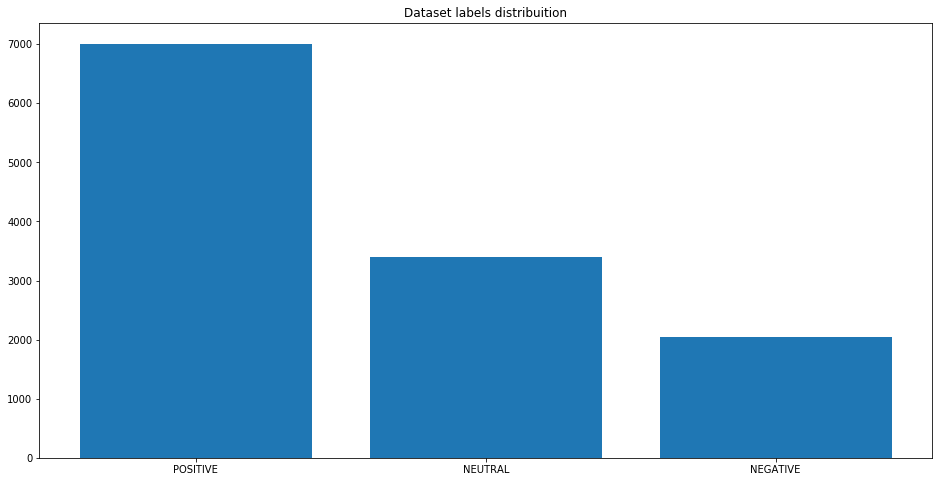

In [11]:
target_cnt = Counter(df1.predict)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

## Preprocess the dataset

In [12]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [13]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [14]:
%%time
df1.text = df1.text.apply(lambda x: preprocess(x))

CPU times: user 645 ms, sys: 7.87 ms, total: 652 ms
Wall time: 669 ms


Divide the data

In [15]:
df_train, df_test = train_test_split(df1, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 9959
TEST size: 2490


### Word2Vec

Word2vec is a two-layer neural net that processes text by “vectorizing” words. Its input is a text corpus and its output is a set of vectors: feature vectors that represent words in that corpus. While Word2vec is not a deep neural network, it turns text into a numerical form that deep neural networks can understand.

In [16]:
%%time
documents = [_text.split() for _text in df_train.text] 

CPU times: user 25.2 ms, sys: 4.88 ms, total: 30.1 ms
Wall time: 30.2 ms


In [17]:
w2v_model = gensim.models.word2vec.Word2Vec(size=W2V_SIZE, 
                                            window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT, 
                                            workers=16)

In [18]:
w2v_model.build_vocab(documents)

In [19]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 1880


In [20]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 12.1 s, sys: 220 ms, total: 12.3 s
Wall time: 4.93 s


(3066620, 5123680)

In [21]:
w2v_model.most_similar("sme")

/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('rtsmallstreams', 0.8960055708885193),
 ('streamboosts', 0.8600207567214966),
 ('supstreamers', 0.844579815864563),
 ('promoteamgamers', 0.842323899269104),
 ('gamingrtweeters', 0.8363938331604004),
 ('rts', 0.8200817704200745),
 ('caster', 0.8105758428573608),
 ('rev', 0.8069382309913635),
 ('supportsquadrts', 0.8013533353805542),
 ('blazedrts', 0.7977819442749023)]

## Tokenize

In [22]:
%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 8.34 µs
Total words 15649


In [23]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 279 ms, sys: 8.25 ms, total: 287 ms
Wall time: 291 ms


## Label Encoder

In [24]:
labels = df_train.predict.unique().tolist()
labels

['POSITIVE', 'NEUTRAL', 'NEGATIVE']

In [25]:
encoder = LabelEncoder()
encoder.fit(df_train.predict.tolist())

y_train = encoder.transform(df_train.predict.tolist())
y_test = encoder.transform(df_test.predict.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (9959, 1)
y_test (2490, 1)


# EDA

In [26]:
df1.head()

,username,text,date,predict
0,stu_fx,phase 2 pewpew halo vfx blender pic twitter co...,2020-07-29 13:35:29 EDT,POSITIVE
1,shovel_spades,chief wait arbiter us megaconstrux halo pic tw...,2020-07-29 13:32:58 EDT,POSITIVE
2,sutrosidetalk,episode 56 applepodcasts go xboxgamesshowcase ...,2020-07-29 13:28:34 EDT,POSITIVE
3,notamuggle11,get halo infinite ok graphics texture problems...,2020-07-29 13:27:58 EDT,NEUTRAL
4,ryno_666,noticed lot similarities previous helmets past...,2020-07-29 13:27:17 EDT,POSITIVE


In [27]:
df1['text'] = df1['text'].str.replace(r'halo', '')
df1['text'] = df1['text'].str.replace(r'infinite', '')
df1['text'] = df1['text'].str.replace(r'twitter', '')
df1['text'] = df1['text'].str.replace(r'pic', '')
df1['text'] = df1['text'].str.replace(r'game', '')
df1['text'] = df1['text'].str.replace(r'xbox', '')
df1['text'] = df1['text'].str.replace(r'play', '')
df1['text'] = df1['text'].str.replace(r'look', '')
df1['text'] = df1['text'].str.replace(r'showcase', '')
df1['text'] = df1['text'].str.replace(r'series', '')
df1['text'] = df1['text'].str.replace(r'ing', '')
df1['text'] = df1['text'].str.replace(r'fuck', '')
df1['text'] = df1['text'].str.replace(r'one', '')

In [ ]:
from wordcloud import WordCloud, STOPWORDS
df1['text'] = df1['text'].fillna("").astype('str')
title_corpus = ' '.join(df1['text'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(title_corpus)

In [ ]:
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [ ]:
negative = df1[df1.predict == 'NEGATIVE']

In [ ]:
negative

In [ ]:
negative['text'] = negative['text'].fillna("").astype('str')
title_corpus = ' '.join(negative['text'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

In [ ]:
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [ ]:
neutral = df1[df1.predict == 'NEUTRAL']

In [ ]:
neutral['text'] = neutral['text'].fillna("").astype('str')
title_corpus = ' '.join(neutral['text'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

In [ ]:
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [ ]:
import datetime
df1['date'] = pd.to_datetime(df1['date']).dt.date
df1

In [ ]:
df1.groupby('date')['text'].nunique().plot(kind='bar')

In [ ]:
july23=df1[df1["date"] == datetime.date(2020, 7, 23)]

In [ ]:
njuly23=df1[df1["date"] != datetime.date(2020, 7, 23)]

In [ ]:
july23

In [ ]:
july23['text'] = july23['text'].fillna("").astype('str')
title_corpus = ' '.join(july23['text'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

In [ ]:
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [ ]:
njuly23

In [ ]:
njuly23['text'] = njuly23['text'].fillna("").astype('str')
title_corpus = ' '.join(njuly23['text'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

In [ ]:
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [ ]:
rt = df1[df1['text'].str.contains('rts', na=False)]

In [ ]:
rt

In [ ]:
rt['text'] = rt['text'].fillna("").astype('str')
title_corpus = ' '.join(rt['text'])
title_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='black', height=2000, width=4000).generate(title_corpus)

In [ ]:
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

In [47]:
from nltk.probability import FreqDist

In [51]:
fdist = FreqDist(x_train)
plt.figure(figsize=(10,10))
fdist.plot(10)

TypeError: unhashable type: 'numpy.ndarray'

# Dummy Classifier(Baseline Model)

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, recall_score

dummy = DummyClassifier(strategy='stratified').fit(x_train, y_train)
dummy_pred = dummy.predict(x_test)

In [ ]:
# checking accuracy
print('Test Accuracy score: ', accuracy_score(y_test, dummy_pred, ))

# checking recall
print('Test Recall score: ', recall_score(y_test, dummy_pred, average='weighted'))

#Checking F1
print('Test F1 score: ', f1_score(y_test, dummy_pred, average='weighted'))